In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

paramdata = np.load('MC_10chains_iter_60000each.npz')
alpha2Darr = paramdata['alpha_arr']
beta2Darr = paramdata['beta_arr']
rstar2Darr = paramdata['r_star_arr']

chain_num, burn = 0, 2000 #
p1, p2 = alpha2Darr[chain_num], beta2Darr[chain_num] #
length = int(p1[chain_num])

#1D accepted parameter arrays[burn:end_of_simulation]
arr1 = p1[1+burn:length+1]
arr2 = p2[1+burn:length+1]

#All accepted parameter values in all chains
all_alphas, all_betas, all_rstars = np.array([]), np.array([]), np.array([])
for i in range(len(alpha2Darr[:, 0])):
    all_alphas = np.append(all_alphas, alpha2Darr[i, 1+burn:int(alpha2Darr[i, 0])+1])
    all_betas = np.append(all_betas, beta2Darr[i, 1+burn:int(beta2Darr[i, 0])+1])
    all_rstars = np.append(all_rstars, rstar2Darr[i, 1+burn:int(rstar2Darr[i, 0])+1])
print(len(all_alphas), len(all_betas), len(all_rstars))

all_gammas = all_rstars

355817 355817 355817


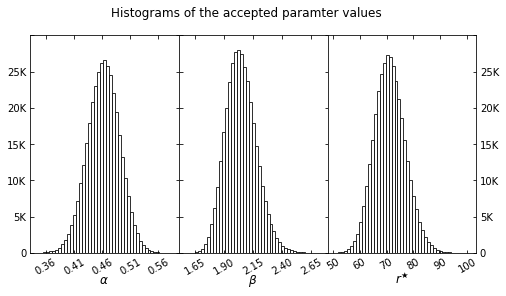

In [122]:
import matplotlib.gridspec as gridspec

def get_1d_hist(parr, nbins, subplot_index):
    counts, bins = np.histogram(parr, bins = nbins)
    binwidth = bins[1] - bins[0]
    plotcounts = np.insert(counts, -1, counts[-1])
    bincentres = (bins[:-1] + bins[1:])/2
    
    ax = plt.subplot(gs1[subplot_index-1])
    ax.bar(bins, plotcounts, width = binwidth, color = '1',
           edgecolor = '0', linewidth = '0.8')
    #ax.step(bins, plotcounts, where='post', c='b')
    #ax.plot(bincentres, counts, 'b')
    #ax.plot([bins[np.argmax(counts)], bins[np.argmax(counts)]], [0, np.max(counts)], 'y')
    
    ax.set_xlim(bins[0], bins[-1])
    ax.set_ylim(bottom = 0, top = 30000)
    ax.tick_params(axis = 'x', direction = 'in', top = True,
                  labelrotation = 30)
    ax.tick_params(axis = 'y', direction = 'in', right = True)
    
    return [ax, counts, bincentres, bins]

nbins = 50

fig = plt.figure(figsize = (8, 4))
fig.suptitle('Histograms of the accepted paramter values')
gs1 = gridspec.GridSpec(1, 3)
gs1.update(wspace=0.0, hspace=0.0) # set the spacing between axes.

#alphas
ax1 = get_1d_hist(all_alphas, nbins, 1)
ax1[0].set_yticklabels(['0','5K','10K','15K','20K','25K'])
ax1[0].xaxis.set_ticks(np.linspace(0.36, 0.56, 5))
ax1[0].set_title(r'$\alpha$', y = -0.17)

#betas
ax2 = get_1d_hist(all_betas, nbins, 2)
ax2[0].set_yticklabels([])
ax2[0].xaxis.set_ticks(np.linspace(1.65, 2.65, 5))
ax2[0].set_title(r'$\beta$', y = -0.17)

#r_stars
ax3 = get_1d_hist(all_rstars, nbins, 3)
ax3[0].yaxis.tick_right()
ax3[0].set_yticklabels(['0','5K','10K','15K','20K','25K'])
ax3[0].xaxis.set_ticks(np.linspace(50, 100, 6))
ax3[0].set_title(r'$r^{\bigstar}$', y = -0.17)

plt.savefig('parameter_histograms', dpi = 200)

(0.46684610561976847, 0.026533756963348643, -0.03184050835601837)
(2.035674387848686, 0.15352915203178608, -0.10235276802119042)
(70.74681460665138, 6.629524587376352, -4.419683058250882)


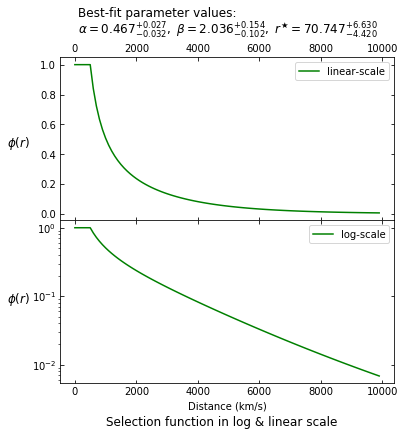

In [129]:
#This cell can only be executed after executing the previous cell

import matplotlib.gridspec as gridspec

al, bt, rs = ax1, ax2, ax3

def get_best_fit(p, param): #p is axis from above cell
    best_p = p[2][np.argmax(p[1])]
    mean_p = np.mean(param)
    std_p = np.std(param)
    mean_p_std = mean_p+std_p
    mean_m_std = mean_p-std_p
    for i in range(nbins):
        if (p[3][i] < mean_p and mean_p < p[3][i+1]):
            mean_bc = p[2][i] #mean bin
        if (p[3][i] < mean_p_std and mean_p_std < p[3][i+1]):
            uperr_bc = p[2][i] #(mean + sigma) bin
        if (p[3][i] < mean_m_std and mean_m_std < p[3][i+1]):
            loerr_bc = p[2][i] #(mean - sigma) bin
    uperrbar = uperr_bc - best_p
    loerrbar = loerr_bc - best_p
    return [(best_p, uperrbar, loerrbar), (mean_p, std_p), (mean_bc, uperr_bc, loerr_bc)]

best_alpha = get_best_fit(al, all_alphas)
best_beta = get_best_fit(bt, all_betas)
best_rstar = get_best_fit(rs, all_rstars)
print(best_alpha[0])
print(best_beta[0])
print(best_rstar[0])


#PLOT

r_s = 5 #in Mpc r_s/h

def phi(r, alpha, beta, r_star): #Galaxy Selection function
    A = r_s**(2*alpha) * (1 + (r_s**2./r_star**2.))**beta
    return A * r**(-2*alpha) * (1 + (r**2./r_star**2.))**-beta

#Plot Selection function
def plot_phi(alpha, beta, r_star):
    distvals = np.arange(5, 100, 1)
    distvalsplot = np.arange(0, 10000, 100)
    
    phivals = [phi(x, alpha[0], beta[0], r_star[0]) for x in distvals]
    phivals = np.insert(phivals, 0, [1, 1, 1, 1, 1])
    
    fig = plt.figure(figsize = (6, 6))
    fig.suptitle('Selection function in log & linear scale', y = 0.05)
    
    gs1 = gridspec.GridSpec(2, 1)
    gs1.update(wspace=0.0, hspace=0.0) # set the spacing between axes.
    
    ax1 = plt.subplot(gs1[0])
    ax1.plot(distvalsplot, phivals, 'g', label = 'linear-scale')
    ax1.legend()
    ax1.xaxis.tick_top()
    ax1.text(x=-2200, y=0.45, s=r'$\phi(r)$', fontsize = 12)
    ax1.text(x=100, y=1.32, s='Best-fit parameter values:', fontsize = 12)
    ax1.text(x=100, y=1.20, s=r'$\alpha=%.3f^{+%.3f}_{%.3f}, \ \beta=%.3f^{+%.3f}_{%.3f}, \ r^{\bigstar}=%.3f^{+%.3f}_{%.3f}$' \
             % (alpha[0], alpha[1], alpha[2], beta[0], beta[1], beta[2], r_star[0], r_star[1], r_star[2]), fontsize = 12)
    ax1.tick_params(axis = 'both', direction = 'in', right = True, bottom = True)
    
    ax2 = plt.subplot(gs1[1])
    ax2.plot(distvalsplot, phivals, 'g', label = 'log-scale')
    ax2.legend()
    ax2.set_yscale('log')
    ax2.set_xlabel('Distance (km/s)')
    ax2.text(x=-2200, y=0.08, s=r'$\phi(r)$', fontsize = 12)
    ax2.tick_params(axis = 'both', direction = 'in', right = True, top = True)
    
    return fig

fig = plot_phi(best_alpha[0], best_beta[0], best_rstar[0])
fig.savefig('selection_function.png', dpi=200)

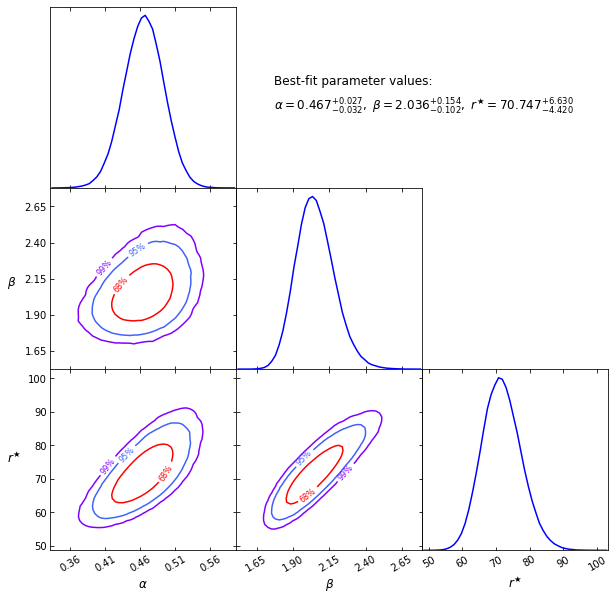

In [120]:
#Required 3C2 Matrix Plot

import matplotlib.gridspec as gridspec
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import scipy.optimize as so
import scipy.ndimage

def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def plot_histogram_fig(param, nbins, subplot_index, subplot_title):
    counts, bins = np.histogram(param, bins = nbins)
    plotcounts = np.insert(counts, -1, counts[-1])
    bincentres = (bins[:-1] + bins[1:])/2
    binwidth = bins[1] + bins[0]
    
    ax = plt.subplot(gs1[subplot_index-1])
    #ax.step(bins, plotcounts, where='post', c='y')
    ax.plot(bincentres, counts, 'b')
    #ax.plot([bins[np.argmax(counts)], bins[np.argmax(counts)]], [0, np.max(counts)], 'y')
    
    ax.tick_params(direction = 'in', top = True, labelrotation = 30,
                   grid_alpha = 0.5) #gridOn = True
    ax.set_xlim(bins[0], bins[-1])
    ax.set_yticks([])
    ax.set_ylim(bottom = 0)
    
    return [ax, counts, bincentres]

def plot_contour_fig(p1, p2, nbins, subplot_index):
    H, xedges, yedges = np.histogram2d(p1, p2, bins = nbins, normed=True)
    H = scipy.ndimage.gaussian_filter(H, sigma = 0.65, order = 0) #filtering
    #X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
    
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1, nbins))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins, 1))
    pdf = (H*(x_bin_sizes*y_bin_sizes).T)
    Z = pdf.T

    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))
    levels = [three_sigma, two_sigma, one_sigma]
    
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    
    ax = plt.subplot(gs1[subplot_index-1])
    ax.tick_params(axis = 'x', direction = 'in', top = True,
                   labelrotation = 30)
    ax.tick_params(axis = 'y', direction = 'in', right = True)
    im = ax.contour(X, Y, Z, levels=levels, cmap = 'rainbow')
    #plt.colorbar(im, ax = ax)
    ax.clabel(im, inline=True, fontsize=8,
              fmt = {levels[0]: '99%', levels[1]: '95%', levels[2]: '68%'})
    ax.set_xlim(xedges[0], xedges[-1])
    return [ax, H, xedges, yedges]

nbins = 50

fig = plt.figure(figsize = (10, 10))
gs1 = gridspec.GridSpec(3, 3)
gs1.update(wspace=0.0, hspace=0.0) # set the spacing between axes.

#Histograms

ax1 = plot_histogram_fig(all_alphas, nbins, 1, subplot_title = 'alpha')
ax1[0].xaxis.set_ticks(np.linspace(0.36, 0.56, 5))
ax1[0].text(x=0.65, y=16000, s='Best-fit parameter values:', fontsize = 12)
ax1[0].text(x=0.65, y=12000, s=r'$\alpha=%.3f^{+%.3f}_{%.3f}, \ \beta=%.3f^{+%.3f}_{%.3f}, \ r^{\bigstar}=%.3f^{+%.3f}_{%.3f}$' \
         % (best_alpha[0][0], best_alpha[0][1], best_alpha[0][2], best_beta[0][0], best_beta[0][1], best_beta[0][2], best_rstar[0][0], best_rstar[0][1], best_rstar[0][2]), fontsize = 12)

ax5 = plot_histogram_fig(all_betas, nbins, 5, subplot_title = 'beta')
ax5[0].xaxis.set_ticks(np.linspace(1.65, 2.65, 5))

ax9 = plot_histogram_fig(all_gammas, nbins, 9, subplot_title = 'gamma')
ax9[0].set_title(r'$r^{\bigstar}$', y = -0.24)

#Contours

ax4 = plot_contour_fig(all_alphas, all_betas, nbins, 4)
ax4[0].xaxis.set_ticks(np.linspace(0.36, 0.56, 5))
ax4[0].yaxis.set_ticks(np.linspace(1.65, 2.65, 5))
ax4[0].text(x=0.27, y=2.1, s=r'$\beta$',fontsize = 12)

ax7 = plot_contour_fig(all_alphas, all_gammas, nbins, 7)
ax7[0].xaxis.set_ticks(np.linspace(0.36, 0.56, 5))
ax7[0].text(x=0.27, y=75, s=r'$r^{\bigstar}$',fontsize = 12)
ax7[0].set_title(r'$\alpha$', y = -0.24)

ax8 = plot_contour_fig(all_betas, all_gammas, nbins, 8)
ax8[0].set_yticklabels([])
ax8[0].xaxis.set_ticks(np.linspace(1.65, 2.65, 5))
ax8[0].set_title(r'$\beta$', y = -0.24)

plt.savefig('matrix_contour_confidence.png', dpi = 200)
plt.show()

# REDUNDANT CODES START HERE

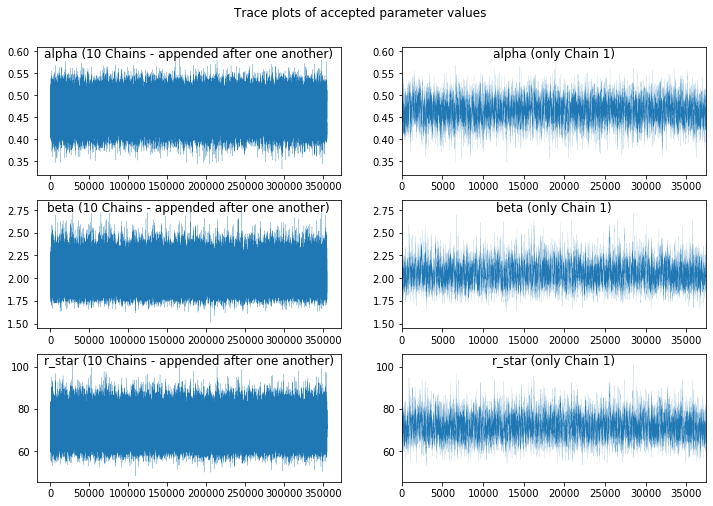

In [74]:
#Trace Plots of accepted parameters

fig = plt.figure(figsize = (12, 8))

fig.suptitle('Trace plots of accepted parameter values', y = 0.95)

ax1 = plt.subplot(321)
ax1.plot(all_alphas, linewidth = 0.2)
ax1.set_title('alpha (10 Chains - appended after one another)', y = 0.87)
ax1 = plt.subplot(322)
ax1.plot(all_alphas, linewidth = 0.08)
ax1.set_xlim(0, int(alpha2Darr[0, 0]))
ax1.set_title('alpha (only Chain 1)', y = 0.87)

ax2 = plt.subplot(323)
ax2.plot(all_betas, linewidth = 0.2)
ax2.set_title('beta (10 Chains - appended after one another)', y = 0.87)
ax2 = plt.subplot(324)
ax2.plot(all_betas, linewidth = 0.08)
ax2.set_xlim(0, int(alpha2Darr[0, 0]))
ax2.set_title('beta (only Chain 1)', y = 0.87)

ax3 = plt.subplot(325)
ax3.plot(all_gammas, linewidth = 0.2)
ax3.set_title('r_star (10 Chains - appended after one another)', y = 0.87)
ax3 = plt.subplot(326)
ax3.plot(all_gammas, linewidth = 0.08)
ax3.set_xlim(0, int(alpha2Darr[0, 0]))
ax3.set_title('r_star (only Chain 1)', y = 0.87)

plt.savefig('parameter_trace_plots.png')

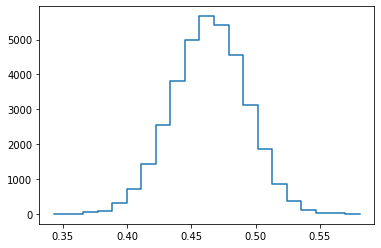

[array([0.34309524, 0.35441583, 0.36573642, 0.37705701, 0.3883776 ,
       0.39969819, 0.41101878, 0.42233937, 0.43365996, 0.44498055,
       0.45630114, 0.46762173, 0.47894232, 0.49026291, 0.5015835 ,
       0.51290409, 0.52422468, 0.53554527, 0.54686586, 0.55818645,
       0.56950704, 0.58082763]), array([   3,   12,   49,   95,  308,  723, 1432, 2564, 3814, 4995, 5667,
       5406, 4546, 3121, 1875,  872,  368,  116,   34,   17,    4]), 36021]


[0.46196143375014764, 0.022641179614682816, -0.033961769422024224]

In [106]:
'''
Functions for getting Selection Function plots,
Histogram plots, and Finding Asymmetrical Error-bars
'''
#Codes correct, do not change

r_s = 5 #in Mpc r_s/h
def phi(r, alpha, beta, r_star): #Galaxy Selection function
    A = r_s**(2*alpha) * (1 + (r_s**2./r_star**2.))**beta
    return A * r**(-2*alpha) * (1 + (r**2./r_star**2.))**-beta

#Plot Selection function
def plot_phi(alpha, beta, r_star):
    distvals = np.arange(5, 100, 1)
    distvalsplot = np.arange(0, 10000, 100)
    
    phivals = [phi(x, alpha, beta, r_star) for x in distvals]
    phivals = np.insert(phivals, 0, [1, 1, 1, 1, 1])
    
    fig = plt.figure()
    
    ax1 = plt.subplot(211)
    ax1.plot(distvalsplot, phivals, label = \
             r'\alpha=%.2f, \beta=%.2f, r^{\bigstar}=%.2f' % (alpha, beta, r_star))
    #plt.yscale('log')
    ax1.set_legend()
    ax1.set_title('Selection function')
    ax1.set_xlabel('Distance (r) (km/s)')
    ax1.set_ylabel(r'\phi(r)')
    
    ax2 = plt.subplot(211)
    ax2.plot(distvalsplot, phivals, label = \
             r'\alpha=%.2f, \beta=%.2f, r^{\bigstar}=%.2f' % (alpha, beta, r_star))
    ax2.yscale('log')
    ax2.set_legend()
    ax2.set_title('Selection function')
    ax2.set_xlabel('Distance (r) (km/s)')
    ax2.set_ylabel(r'\phi(r)')
    #plt.savefig('zzz.png')


#Get histogram
def histogram(param, chain_num, nbins=11): #param is 2D array
    burn_end = 1500
    nvals = int(param[chain_num-1, 0])
    parr = param[chain_num-1, 1+burn_end:nvals+1]
    
    tot_counts = nvals - burn_end
    counts, bins = np.histogram(parr, bins = nbins)
    plotcounts = np.insert(counts, -1, counts[-1])
    
    binwidth = bins[1] - bins[0]
    #plt.hist(parr, bins = 25)
    plt.step(bins, plotcounts, where = 'post')
    plt.xlim(bins[0]-binwidth, bins[-1]+binwidth)
    plt.show()
    
    return [bins, counts, tot_counts]


#Get median value and 1 sigma errorbars
def find_errorbars(bins, counts, tot_counts):
    if int(np.sum(counts)) != tot_counts: print('Oopsieee!!!')
    sigmacount = 0.341 * tot_counts
    medianbin = np.argmax(counts)
    medianval = (bins[medianbin] + bins[medianbin+1])/2
    
    #upper-errorbar
    sumcounts = counts[medianbin]/2
    for i in range(medianbin+1, len(counts)):
        sumcounts += counts[i]
        if (sumcounts >= sigmacount):
            upsigmaval = (bins[i] + bins[i+1])/2
            break
    uperror = upsigmaval - medianval
    
    #lower-errorbar
    sumcounts = counts[medianbin]/2
    for i in range(medianbin-1, 0, -1):
        sumcounts += counts[i]
        if (sumcounts >= sigmacount):
            losigmaval = (bins[i] + bins[i+1])/2
            break
    loerror = losigmaval - medianval
    
    return [medianval, uperror, loerror]


a = histogram(alpha2Darr, chain_num, 21)
print(a)
find_errorbars(a[0], a[1], a[2])

[0.00026864958123638046, 0.0014185255187216736, 0.008848718236925722]


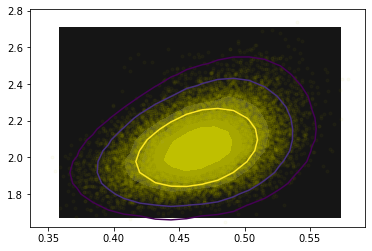

In [226]:
#Confidence-interval plot 1sigma, 2sigma, 3sigma

import scipy.optimize as so
import scipy.ndimage

def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
    """
    
    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))
    
    H = scipy.ndimage.gaussian_filter(H, sigma = 0.8, order = 0) #filtering
    
    pdf = (H*(x_bin_sizes*y_bin_sizes).T)
    
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))
    levels = [three_sigma, two_sigma, one_sigma]
    
    print(levels)
    
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    
    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        #plt.clabel(contour, inline=True, fontsize=8)
    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        #plt.clabel(contour, inline=True, fontsize=8)
    
    return contour

def test_density_contour():
    arr1_1, arr2_1 = all_alphas, all_betas
    #arr1_1 = scipy.ndimage.zoom(arr1, 100) #Do not go above 1000 or HANG
    #arr2_1 = scipy.ndimage.zoom(arr2, 100)
    density_contour(arr1_1, arr2_1, 21, 21)
    
    #Show other contours as filled 
    H, xedges, yedges = np.histogram2d(arr1, arr2, bins = 21)
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    plt.contourf(X, Y, H.T, cmap='gray')
    
    plt.scatter(arr1, arr2, alpha = 0.04, marker = '.', c = 'y')

test_density_contour()

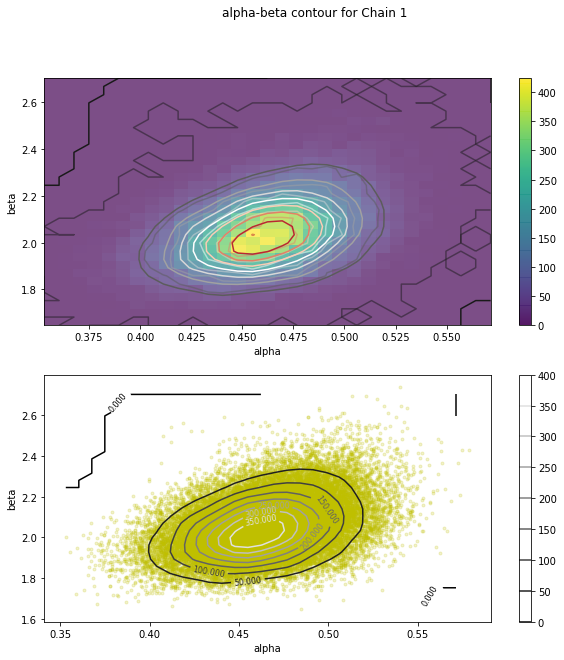

In [157]:
#Contour Plot along with smoothening using gaussian_filter

import scipy.ndimage

H, xedges, yedges = np.histogram2d(arr1, arr2, bins = 31)
Z = H.T #important for np.histogram2d
Z_gauss = scipy.ndimage.gaussian_filter(Z, sigma = 0.8, order = 0) #filtering
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])

fig = plt.figure(figsize = (10, 10))

fig.suptitle('alpha-beta contour for Chain 1')

ax1 = fig.add_subplot(211)

#Show square histogram levels
im = ax1.imshow(Z, extent=[xedges[0], xedges[-2], yedges[0], yedges[-2]],
           origin='lower', alpha=0.7, aspect = 'auto') #seismic, plasma
plt.colorbar(im, ax = ax1)

ax1.contour(X, Y, Z, alpha=0.5, cmap='RdGy_r')
ax1.contour(X, Y, Z_gauss, cmap='RdGy_r')
#indices = np.random.randint(0, arr1.size, 1000)
#ax1.scatter(arr1[indices], arr2[indices], alpha = 0.2, marker = '.', c = 'y')
#ax1.set_xlim(0.38, 0.53)
#ax1.set_ylim(1.7, 2.5)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')

ax2 = fig.add_subplot(212)

im = ax2.contour(X, Y, Z_gauss, cmap='gray')
plt.colorbar(im, ax = ax2)
ax2.clabel(im, inline=True, fontsize=8)
ax2.scatter(arr1, arr2, alpha = 0.2, marker = '.', c = 'y')
#ax2.set_xlim(0.38, 0.53)
#ax2.set_ylim(1.7, 2.5)
ax2.set_xlabel('alpha')
ax2.set_ylabel('beta')
#plt.savefig('contour_plot.png', dpi = 200)

array([1.72, 1.92, 2.12, 2.32, 2.52, 2.72])

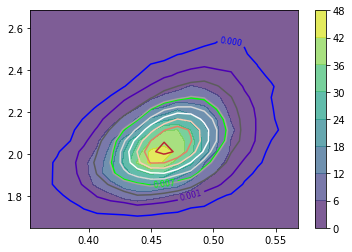

In [231]:
#By estimating gaussian kernel

#Shows difference between estimating gaussian kernel for contour
#and
#Using Histogram to plot contour

import scipy.stats
import scipy.optimize as so

nbins = 21
H, xedges, yedges = np.histogram2d(arr1, arr2, bins = nbins, normed = True)
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
gkde = scipy.stats.gaussian_kde([arr1, arr2])
Z = np.array(gkde.evaluate([X.flatten(),Y.flatten()])).reshape(X.shape)

def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1, nbins))
y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins, 1))
pdf = (Z*(x_bin_sizes*y_bin_sizes).T)

one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))
levels = [three_sigma, two_sigma, one_sigma]

contour = plt.contour(X, Y, pdf, levels, alpha=1, cmap='brg')
plt.clabel(contour, inline=True, fontsize=8)
plt.contour(X, Y, Z, alpha=1, cmap='RdGy_r')
plt.contourf(X, Y, H.T, alpha=0.7)
plt.colorbar()

In [369]:
from matplotlib.image import NonUniformImage

fig = plt.figure(figsize=(7, 3))

ax = fig.add_subplot(211, title='pcolormesh: actual edges',
        aspect='equal')
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H.T)

ax = fig.add_subplot(212, title='NonUniformImage: interpolated',
                     xlim=xedges[[0, -1]], ylim=yedges[[0, -1]])
im = NonUniformImage(ax, interpolation='bilinear')
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
im.set_data(xedges[:-1], yedges[:-1], H.T)
ax.images.append(im)
plt.show()

TypeError: 'NoneType' object is not iterable

<Figure size 504x216 with 2 Axes>